In [ ]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import logging
from pathlib import Path
import textwrap
import copy
from PIL import Image, ImageDraw, ImageFont
from waveshare_epd import epd2in7b

In [4]:
import constants


In [5]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

In [6]:
class textblock:
    '''Class for creating blocks of formatted and wrapped text as images using PIL(Pillow)
    
    Args
    ----
        resolution (2-tuple): width (x), height (y) in pixles of canvas
        font (Path): path to ttf font
        size (int): size in points to use for rendering text
        maxRows (int): maximum number of rows to produce (overflow rows will be discarded)
        text (str): unformatted text
        charPerRow (int): maximum number of rows to use per row
            this is automatically calculated using font, display size and english letter 
            distribution. Other letter distributions can be provided see CHARDIST
        charDist (dict): letter use distribution for calculating maximum number of char/row 
            for character set. Default set is for [A..Z, a..z].
            Format: CHARDIST = {'A': 0.0796394951934866, 'B': 0.0480421724743304,}
            For more languages see: 
                * https://en.wikipedia.org/wiki/Letter_frequency 
                * https://www.sttmedia.com/characterfrequencies
            
    Attributres
    -----------
        height (int): height in pixles of the display
        width (int): width in pixles of the display
        font (str): path to ttf font
        text (str): unformatted text
        charPerRow (int): maximum number of characters to allow per row before wrapping
        maxRows (int): maximum number of rows of text to produce (overflow rows will be discarded)
        __charDist (dict): private var containing character distribution 
        formattedText (str): word-wrapped text
    
    Methods
    -------
    
    
    '''
    def __init__(self, resolution=(264, 176), font=constants.FONT, size=24, maxRows=3, text='',
                 charPerRow=None, charDist=constants.USA_CHARDIST):
        self.height = resolution[0]
        self.width = resolution[1]
        self.font = self.setFont(fontPath=font, size=size)
        self.__charDist = charDist
        self.charPerRow = charPerRow
        self.maxRows = maxRows
        self.text = text
        
    def setFont(self, fontPath, size):
        logger.debug(f'font: {Path(fontPath).absolute()}: {Path(fontPath).exists()}')
        font = ImageFont.truetype(str(Path(fontPath).absolute()), size)
        return(font)
    
    
    @property
    def charPerRow(self):
        return self.__charPerRow
    
    @charPerRow.setter
    def charPerRow(self, charPerRow):
        if charPerRow:
            self.__charPerRow = charPerRow
            return(charPerRow)
        s = ''
        n = 1000
        testFont = self.font
        # create a string of characters containing the letter distribution
        for char in self.__charDist:
            s = s+(char*int(self.__charDist[char]*n))
        sLenPX = testFont.getsize(s)[0] # string length in Pixles
        avgCharLen = sLenPX/len(s)
        charPerRow = round(self.height/avgCharLen)        
        self.__charPerRow = charPerRow
        
    @property
    def text(self):
        return self.__text

    @text.setter
    def text(self, text):
        if not text:
            text = ' '
        self.__text = text
        self.formattedText = self.wrapText(text)
        
    def wrapText(self, text='', charPerRow=None, maxRows=None):
        if not charPerRow:
            charPerRow = self.charPerRow
        if not maxRows:
            maxRows = self.maxRows
        try:
            wrapper = textwrap.wrap(text, width=charPerRow)
        except AttributeError as e:
            raise ValueError(f'Attribute Error: {text} is not a string; it appears to be {type(text)}')
        myText = "\n".join(wrapper[0:maxRows])
        return(myText)
    
    def textImg(self, text=None):
        blankImage = Image.new('1', (self.height, self.width), 255) # create a blank image 
        myImage = ImageDraw.Draw(blankImage) # cr
        if text:
            myText = self.wrapText(text)
        else:
            myText = self.formattedText
        
        # this is suspect code - I think this works because it makes a shallow copy; probably need to 
        # do this in a more direct and obvious way
        myImage.text((0, 0), myText, font=self.font, fill=0)
        
        return(blankImage)
    
    

In [30]:
epd = epd2in7b.EPD()
track = textblock(resolution=(epd.height, epd.width), maxRows=3, size=24)
empty = textblock(resolution=(epd.height, epd.width), maxRows=1, size=10)

DEBUG:__main__:font: /home/pi/src/slimpi_epd/fonts/Open_Sans/OpenSans-Regular.ttf: True
DEBUG:__main__:font: /home/pi/src/slimpi_epd/fonts/Open_Sans/OpenSans-Regular.ttf: True


In [31]:
track.text = 'Old education him departure any arranging one prevailed. Their end whole might began her. Behaved the comfort another fifteen eat. Partiality had his themselves ask pianoforte increasing discovered. So mr delay at since place whole above miles. He to observe conduct at detract because. Way ham unwilling not breakfast furniture explained perpetual. Or mr surrounded conviction so astonished literature. Songs to an blush woman be sorry young. We certain as removal attempt.'

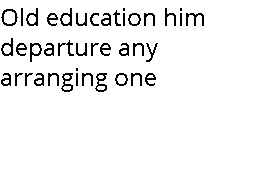

In [32]:
track.textImg()

In [28]:
epd.init()

DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release


0

In [29]:
epd.display(epd.getbuffer(track.textImg()), epd.getbuffer(empty.textImg()))

DEBUG:root:Horizontal
DEBUG:root:Horizontal
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
